In [ ]:
!git clone https://github.com/thim0o/CoinDetector

Cloning into 'CoinDetector'...
remote: Enumerating objects: 1415, done.
remote: Counting objects: 100% (1415/1415), done.
remote: Compressing objects: 100% (1402/1402), done.
remote: Total 4471 (delta 31), reused 1381 (delta 11), pack-reused 3056
Receiving objects: 100% (4471/4471), 163.08 MiB | 22.65 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (3057/3057), done.


In [ ]:
import os

images_classes_path = '/content/CoinDetector/train'

images_classes_list = os.listdir(images_classes_path)

num_classes = len(images_classes_list)
print("total {} classes".format(num_classes))

total 6 classes


In [ ]:
%load_ext tensorboard
import datetime
!rm -rf ./logs/ 

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


preprocess


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image      
import random

In [ ]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.4,
)

train_generator = datagen.flow_from_directory(
        images_classes_path,
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        subset="training"
)

val_generator = datagen.flow_from_directory(
        images_classes_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,
        subset="validation"
)

test_dir = '/content/CoinDetector/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        shuffle=False,
        batch_size=1,
        class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 1756 images belonging to 6 classes.
Found 1167 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


model 

In [ ]:
import keras
from keras.layers import Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam 

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(include_top=True, weights='imagenet', input_shape=(224, 224, 3))

Remove the last 4 layers

In [ ]:
for i in range(4):
  base_model.layers.pop()
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Fine-tuning the model

In [ ]:
x = base_model.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate = .5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.inputs, outputs=predictions)

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True 
    
for layer in model.layers[:-7]:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten False
20 fc1 True
21 fc2 True
22 predictions True
23 batch_normalization_1 True
24 dense_2 True
25 dropout_1 True
26 dense_3 True


In [ ]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [ ]:
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

my_callbacks = [checkpoint, tensorboard_callback]


AlreadyExistsError: ignored

In [ ]:
model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(train_generator), 
                              validation_data=val_generator, 
                              validation_steps=len(val_generator),
                              epochs=1,
                              callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


 1/28 [>.............................] - ETA: 23:41 - loss: 1.7948 - accuracy: 0.1406

KeyboardInterrupt: ignored

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True

In [ ]:
params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=3,
                                callbacks=my_callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
28/28 [==============================] - 1526s 55s/step - loss: 0.6808 - accuracy: 0.9379 - val_loss: 1.6228 - val_accuracy: 0.9537
Epoch 2/3
28/28 [==============================] - 1529s 55s/step - loss: 0.1992 - accuracy: 0.9801 - val_loss: 1.5017 - val_accuracy: 0.9666
Epoch 3/3
28/28 [==============================] - 1516s 55s/step - loss: 0.0686 - accuracy: 0.9943 - val_loss: 1.3887 - val_accuracy: 0.9580


0.24572678   :   20cent
0.18099415   :   50cent
0.15391497   :   1euro
0.14321549   :   5cent
0.13947749   :   2euro
0.13667102   :   10cent


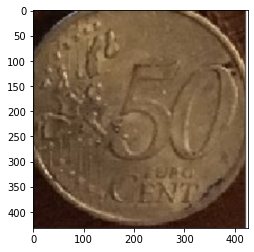

In [ ]:
def predict_images(path):
    img = plt.imread(path)
    plt.imshow(img)


    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((224, 224))

    probabilities = model.predict(np.expand_dims(image, axis=0))
    type_list = tuple(zip(val_generator.class_indices.values(), val_generator.class_indices.keys()))

    for i in probabilities.argsort()[0][-6:][::-1]: 
         print(probabilities[0][i], "  :  " , type_list[i][1])

predict_images('/content/1-6kSsgT5drG4n1fE68ACFHqjzbc9nL_Q/MyDrive/test3.jpg')